## Introduction
Relation prediction on WebChild property data

In [59]:
import matplotlib.pyplot as plt
import numpy as np
from nltk.stem.wordnet import WordNetLemmatizer
import random, os, time, faiss, torch

In [60]:
from util import *

## Setup directories

In [61]:
# input_file
webchild = "./data/wc/property.txt"

# ouput_file
wc_gold_file = "./data/wc/wc_gold_500k.tsv"
wc_entity_file = "./data/wc/entities.txt"
wc_entity2id_file = "./data/wc/entity2id.txt"
wc_entity2text_file = "./data/wc/entity2text.txt"
wc_entity2textlong_file = "./data/wc/entity2textlong.txt"
wc_relation_file = "./data/wc/relations.txt"
wc_relation2id_file = "./data/wc/relation2id.txt"
wc_relation2text_file = "./data/wc/relation2text.txt"
wc_train_500k = "./data/wc/train.tsv"
wc_dev_500k = "./data/wc/dev.tsv"
wc_test_500k = "./data/wc/test.tsv"
wc_train2id_500k = "./data/wc/train2id.txt"
wc_dev2id_500k = "./data/wc/valid2id.txt"
wc_test2id_500k = "./data/wc/test2id.txt"

## Data Preperation

In [62]:
def generate_gold_file(lines):
    # Generate TSV file for relation classification
    wn_gold_all = []
    i = 0
    for line in lines:
        node1_id = line[0]
        relation_id = line[1]
        node2_id = line[2]
        node1_labels = line[3]
        node2_labels = line[4]
        relation_label = line[5]

        # modeify the node labels, check with leve distance
        sent = line[8].replace("[","").replace("]","")
        node1_label = multiple_labels(node1_labels,node1_id)
        node2_label = multiple_labels(node2_labels,node2_id)

        wn_gold_all.append([node1_label, relation_label, node2_label, node1_id, node2_id,relation_id,sent])
        i += 1
        if i%10000==1:
            print(f"\r {i}/{len(lines)}", end="")
        
    return wn_gold_all

def id_generation(id_):
    # transfer property.txt file id to kgtk format
    if id_ == "-":
        return "wn:"
    id_ = id_.replace("#",".").replace(" ","_")
    id_="wn:"+id_
    return id_

def label_generation(id_):
    # transfer property.txt file id to kgtk format label
    return id_.split(":")[1].split(".")[0].replace("_"," ")
    
def write_split_file(filename1, fielename2, lines,entity2detail,relation2detail):
    # write train & train2id
    with open(filename1,"w",newline='') as f1, open(fielename2,"w",newline='') as f2:
        w1 = csv.writer(f1, delimiter='\t')
        w2 = csv.writer(f2, delimiter='\t')

        #write head
        w2.writerow([len(lines)])
        for line in lines:
            # wtite content
            entity1, relation, entity2 = line
            entity1_id, entity1_text, entity1_textlong = entity2detail[entity1]
            entity2_id, entity2_text, entity2_textlong = entity2detail[entity2]
            relation_id, relation_text, relation_textlong = relation2detail[relation]
            w1.writerow([entity1,relation,entity2])
            w2.writerow([entity1_id,entity2_id,relation_id,])

In [63]:
# load data
head, lines = load_file(webchild,encoding="latin1")

In [64]:
# triple example
lines[0]

['aardvark#n#1',
 'quality#n#1',
 'general#a#1',
 'aardvark',
 'general',
 '44',
 '1',
 '1',
 '2gms,',
 '0.453608',
 'a']

In [65]:
# generate file to kgtk file type
# node1	relation	node2	node1;label	node2;label	relation;label	relation;dimension	source	sentence

temp = []

for line in lines:
    entity1_id = id_generation(line[0])
    relation_id = id_generation(line[1])
    entity2_id = id_generation(line[2])
    entity1_label = line[3]
    entity2_label = line[4]
    relation_label = label_generation(relation_id)
    temp.append([entity1_id,relation_id,entity2_id,entity1_label,entity2_label,relation_label,"","wc",""])

In [66]:
# kgtk_file example
temp[0]

['wn:aardvark.n.1',
 'wn:quality.n.1',
 'wn:general.a.1',
 'aardvark',
 'general',
 'quality',
 '',
 'wc',
 '']

In [67]:
lines = temp

**Data Description**

In [68]:
# check whether it has triplr without predicate
# if yes, remove this triples
# check number of relations, unique nodes, total edges, distribution of relations, most frequent nodes

valid_lines = []
invalid_lines_count = 0
unique_nodes = dict()
relations_dict = dict()

node2text = dict()
relation2text = dict()

for line in lines:
    node1_id = line[0]
    node2_id = line[2]
    relation_id = line[1]
    
    node1_label = line[3]
    node2_label = line[4]
    relation_label = line[5]
    
    if relation_id == "wn:":
        #filter no relation
        invalid_lines_count += 1
        continue
    
    # triple with relation
    valid_lines.append(line)
    
    # count the number of unique nodes
    unique_nodes[node1_id] = unique_nodes.get(node1_id,0)+1
    unique_nodes[node2_id] = unique_nodes.get(node2_id,0)+1
    
    # count the number of unique relations
    relations_dict[relation_id] = relations_dict.get(relation_id,0)+1
    
    node2text[node1_id] = node1_label
    node2text[node2_id] = node2_label
    relation2text[relation_id] = relation_label
    
# Summary
print(f"The number of triples without relations: {invalid_lines_count}")
print(f"The number of triples with relation: {len(valid_lines)}")
print(f"The number of unique nodes: {len(unique_nodes)}")
print(f"The number of unique relations: {len(relations_dict)}")
max_fre_nodes = max(unique_nodes, key=unique_nodes.get)
print(f"The most frequent node: {max_fre_nodes}")
max_fre_relation = max(relations_dict, key=relations_dict.get)
print(f"The most frequent relation: {max_fre_relation}")

The number of triples without relations: 3673697
The number of triples with relation: 2836191
The number of unique nodes: 48076
The number of unique relations: 27
The most frequent node: wn:new.a.1
The most frequent relation: wn:quality.n.1


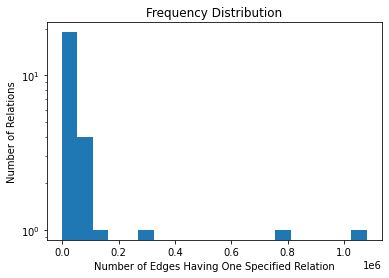

In [69]:
plt.hist(relations_dict.values(),log=True,bins=20)
plt.title('Frequency Distribution')
plt.xlabel('Number of Edges Having One Specified Relation')
plt.ylabel('Number of Relations')
plt.show()

In [70]:
# random select 500k lines from data
valid_lines_10k = random.choices(valid_lines, k=100000)

# generate 500k lines gold file
wc_gold_500k = generate_gold_file(valid_lines_10k)

 90001/100000

**Generate Data File**

1. Generate Train, Dev and Test Dataset.
2. Generate basic data files used for kg-bert

In [71]:
entity2detail = dict()
relation2detail = dict()

idx= 0
for node_id in unique_nodes:
    # build dict for each entity with their id, text, and long text
    definition = wn.synset(node_id.split(":")[1]).definition()

    entity_label = node2text[node_id]
    entity2detail[node_id]=[idx, entity_label, definition]
    idx += 1

idx = 0
for relation_id in relation2text:
    # build dict for each relation with their id, text, and long text
    definition = wn.synset(relation_id.split(":")[1].replace(" ","_")).definition()
    relation_label = relation2text[relation_id]
    relation2detail[relation_id]=[idx, relation_label, definition]
    idx += 1
    
# Transfer gold data to the structure of kg-bert
kgBert_data_sent = [[_[3],_[5],_[4],_[6]] for _ in wc_gold_500k]

In [72]:
# write file
# entities.txt, entity2id, entity2text, entity2textlong

with open(wc_entity_file,"w",newline='') as f1, open(wc_entity2id_file,"w",newline='') as f2,\
open(wc_entity2text_file, "w",newline='') as f3, open(wc_entity2textlong_file,"w",newline='') as f4:
    w1 = csv.writer(f1, delimiter='\t')
    w2 = csv.writer(f2, delimiter='\t')
    w3 = csv.writer(f3, delimiter='\t')
    w4 = csv.writer(f4, delimiter='\t')
    
    #write head
    w2.writerow([len(entity2detail)])
    for entity in entity2detail:
        # wtite content
        entity_id, entity_text, entity_textlong = entity2detail[entity]
        w1.writerow([entity,])
        w2.writerow([entity,entity_id])
        w3.writerow([entity,entity_text])
        w4.writerow([entity,entity_textlong])
        
# relations.txt, rekation2id.txt, relation2text.txt
wc_relation_file = "./data/wc/relations.txt"
wc_relation2id_file = "./data/wc/relation2id.txt"
wc_relation2text_file = "./data/wc/relation2text.txt"
with open(wc_relation_file,"w",newline='') as f1, open(wc_relation2id_file,"w",newline='') as f2,\
open(wc_relation2text_file, "w",newline='') as f3:
    w1 = csv.writer(f1, delimiter='\t')
    w2 = csv.writer(f2, delimiter='\t')
    w3 = csv.writer(f3, delimiter='\t')
    
    #write head
    w2.writerow([len(relation2detail)])
    for relation in relation2detail:
        # wtite content
        relation_id, relation_text, relation_textlong = relation2detail[relation]
        w1.writerow([relation,])
        w2.writerow([relation,relation_id])
        w3.writerow([relation,relation_text])

In [73]:
# Split train, dev, test file

random.shuffle(kgBert_data_sent)

# define ratio of train, dev, test
train_ratio = 0.8
dev_ratio = 0.1
test_ratio = 1 - train_ratio - dev_ratio

len_gold = len(kgBert_data_sent)
train, dev, test = np.split(kgBert_data_sent,[int(train_ratio*len_gold),int((train_ratio+dev_ratio)*len_gold)])
print("length of train, dev, test: ", len(train), len(dev), len(test))

# write train & train2id
write_split_file(wc_train_500k, wc_train2id_500k, [_[0:-1] for _ in train],entity2detail,relation2detail)

# write dev & dev2id
write_split_file(wc_dev_500k, wc_dev2id_500k, [_[0:-1] for _ in dev],entity2detail,relation2detail)

# write test & test2id
write_split_file(wc_test_500k, wc_test2id_500k, [_[0:-1] for _ in test],entity2detail,relation2detail)

length of train, dev, test:  80000 10000 10000


In [74]:
#example of gold file
train[0]

array(['wn:simulation.n.3', 'wn:state.n.2', 'wn:immune.a.1', ''],
      dtype='<U37')

## Baseline Running

**Random Baseline**

In [77]:
def relation_list_generation(file_path):
    with open(file_path,"r") as f:
        relation_list = []
        for line in f:
            relation_list.append(line.strip().split("\t")[0])
        return relation_list

def MRS(wn_gold, relation_list):
    # Random Baseline calculation
    # only predict subject
    wn_predict = []
    for line in wn_gold:
        entity1  = line[0]
        entity2 = line[2]
        relation_label = line[3]
        
        # generate all possible combination of "_"&"-" and check whether it can find sysets.
        # if the combination can generate sysets, use this combinations to generate candidates
        
        relation_id = wn.synset(random.choice(relation_list).split(":")[1])
        
        node1_id=""
        node2_id=""
        
        wn_predict.append([entity1, relation_id, entity2, relation_label])
        
    return wn_predict

def modify_data(lines,relation2detail):
    # add label in the dataset used to make prediction
    for line in lines:
        entity1, relation, entity2, sent = line
        relation_label = relation2detail[relation][1]
        yield entity1, relation, entity2, relation_label, sent

def validation(wn_predict, wn_gold):
    # valid the accuracy of prediction: only compare the accuracy of prediction
    
    correct = 0
    
    for predict, actual in zip(wn_predict, wn_gold):
        predict_label1 = predict[1]
        actual_label1 = wn.synset(actual[1].split(":")[1].replace(" ","_"))
        if not predict_label1:
            continue
        if predict_label1 == actual_label1:
            # predict and actual is same
            correct += 1
            
    return correct/len(wn_predict)

In [78]:
relation_list = relation_list_generation(wc_relation2text_file)

In [79]:
# modify train, dev, test data
train_modify = list(modify_data(train,relation2detail))
dev_modify = list(modify_data(dev,relation2detail))
test_modify = list(modify_data(test,relation2detail))

In [80]:
#train dataset
wc_ran_train_predict = MRS(train_modify,relation_list)
accuracy = validation(wc_ran_train_predict, train_modify)
print("Accuracy of train dataset (random baseline): ", accuracy)

#dev dataset
wc_ran_dev_predict = MRS(dev_modify,relation_list)
accuracy = validation(wc_ran_dev_predict, dev_modify)
print("Accuracy of dev dataset (random baseline): ", accuracy)

#test dataset
wc_ran_test_predict = MRS(test_modify,relation_list)
accuracy = validation(wc_ran_test_predict, test_modify)
print("Accuracy of test dataset (random baseline): ", accuracy)

Accuracy of train dataset (random baseline):  0.0372375
Accuracy of dev dataset (random baseline):  0.0387
Accuracy of test dataset (random baseline):  0.0386


**MFS Baseline**

In [81]:
def MFS(wn_gold, most_frequency_relation = "wn:quality.n.1"):
    # Frequent Baseline Calculation
    wn_predict = []
    for line in wn_gold:
        entity1  = line[0]
        entity2 = line[2]
        relation_label = line[3]
        
        # generate all possible combination of "_"&"-" and check whether it can find sysets.
        # if the combination can generate sysets, use this combinations to generate candidates
        relation_id = wn.synset(most_frequency_relation.split(":")[1])
        
        node1_id=""
        node2_id=""
        
        wn_predict.append([entity1, relation_id, entity2, relation_label])
    return wn_predict

In [82]:
#train dataset
wc_ran_train_predict = MFS(train_modify)
accuracy = validation(wc_ran_train_predict, train_modify)
print("Accuracy of train dataset (frequency baseline): ", accuracy)

#dev dataset
wc_ran_dev_predict = MFS(dev_modify)
accuracy = validation(wc_ran_dev_predict, dev_modify)
print("Accuracy of dev dataset (frequency baseline): ", accuracy)

#test dataset
wc_ran_test_predict = MFS(test_modify)
accuracy = validation(wc_ran_test_predict, test_modify)
print("Accuracy of test dataset (frequency baseline): ", accuracy)

Accuracy of train dataset (frequency baseline):  0.3814875
Accuracy of dev dataset (frequency baseline):  0.3757
Accuracy of test dataset (frequency baseline):  0.3913


**STBert Baseline**

In [90]:
model_STB = SentenceTransformer('bert-base-nli-mean-tokens')

In [91]:
relation_list[:10]

['wn:quality.n.1',
 'wn:trait.n.1',
 'wn:age.n.1',
 'wn:color.n.1',
 'wn:beauty.n.1',
 'wn:shape.n.2',
 'wn:size.n.1',
 'wn:state.n.2',
 'wn:weight.n.1',
 'wn:emotion.n.1']

In [92]:
train_modify[0]

('wn:simulation.n.3', 'wn:state.n.2', 'wn:immune.a.1', 'state', '')

In [93]:
def vector_normalize(vector):
    # input should be a numpy array
    # change to unit vector
    return vector / (vector**2).sum()**0.5

def label2sentence2sent(relation_id, model,label_synsets,sents_combine):

    candidates = wn.synset(relation_id.split(":")[1])
    candits_sent = candidates.definition()
    
    sents_combine.append(candits_sent)
    label_synsets.append(candidates)
            
    return label_synsets,sents_combine

def max_candidate_faiss(label_,sent_embedding_,label_embeddings):
    # return the max similarity candidates
    #output: [[similarity, synset, the pos of synset]]

    sent_embedding_ = vector_normalize(sent_embedding_)
        
    top_n = 1
    index_ = label_embeddings[1]
    _, I = index_.search(np.array([sent_embedding_]), top_n)
    #print(int(I),label_embeddings[label_][0])
    return label_embeddings[0][int(I)]

def candidates_embeddings_faiss(relation_list, model):
    # generate label node id defination embeddings from file
    # output:{"label_name":[[node_id, embedding of node_id defination],[X,X],[X,X]]}
    
    # store label, synset
    label_synsets = []
    # store the defination sentence of synset
    sents_combine = []
    
    embeddings = list()
    
    sents_combine =[]
    label_synsets =[]
    
    for relation in relation_list:
        candidate = wn.synset(relation.split(":")[1])
        candit_sent = candidate.definition()

        sents_combine.append(candit_sent)
        label_synsets.append(candidate)
        
        #if count1%1000==0:print(f"\r lines counting {count1}/{length1}",end="")

    # generate embedding of sentence
    start = time.time()
    sents_embed = model.encode(sents_combine)
    sents_embed = [vector_normalize(_) for _ in sents_embed]
    # dimension of faiss
    d = len(sents_embed[0])
    end = time.time()
    
    # write embedding into faiss
    index_ = faiss.IndexFlatL2(d)
    index_.add(np.array(sents_embed))
    
    return [label_synsets,index_]

def sentence_embedding_faiss(wn_gold, model, label_embeddings = None):
    # use sentences embedding to find most similar candit
    wn_predict = []
    sents_combine = []
    
    length1 = len(wn_gold)
    count1 = 0
    for line in wn_gold:
        label1 = line[0]
        label2 = line[2]
        relation_label=line[1]
        
        sentence = label1 + f" {relation_label} "+ label2
        sents_combine.append(sentence)
        
        count1 += 1
        #if count1%1000==0:print(f"\r lines counting {count1}/{length1}",end="")
    # obtain sentence embedding
    start = time.time()
    sents_embedding = model.encode(sents_combine)
    end = time.time()
    #print(f"model time: {end-start}")
    
    length2 = len(wn_gold)
    count2 = 0
    for line,sent_embedding in zip(wn_gold,sents_embedding):
        relation_label = line[3]

        #obtain the max similar item for label1
        relation_id = max_candidate_faiss(relation_label,sent_embedding,label_embeddings) 
                
        wn_predict.append([line[0], relation_id, line[2],line[3],line[4]])
        count2 +=1
        #print(f"\r line countung {count2}/{length2}", end="")
    return wn_predict

def chunks_divide(data, num=10000):
    for idx in range(0,len(data),num):
        yield data[idx:idx+num]

def process_data_inChunk(data,relation_list, model, chunk_num = 10000):
    # data file is processed in chunks
    total = 0
    total_predict = []
    start_total = time.time()
    
    label_embeddings = candidates_embeddings_faiss(relation_list, model)
    for sub_data in chunks_divide(data, num=chunk_num):
        start = time.time()
        predict = sentence_embedding_faiss(sub_data, model,label_embeddings = label_embeddings)
        
        total_predict += predict
        process_num = len(sub_data)
        total +=process_num
        usedtime = time.time() - start
        print(f"The time used for this iteration: {usedtime}, finished lines {total}/{len(data)}")
    accuracy = validation(total_predict, data)
    
    total_time = time.time()-start_total
    print(f"Process finished! Total time: {total_time}")
    return total_predict, accuracy

In [94]:
#wc_ran_train_predict, accuracy = process_data_inChunk(dev_modify[:1000],relation_list, model_STB, chunk_num = 1000)

In [95]:
#train dataset
wc_stb_train_predict, accuracy = process_data_inChunk(train_modify,relation_list, model_STB, chunk_num = 10000)
print("Accuracy of train dataset (STB baseline): ", accuracy)
print("\n")
#dev dataset
wc_stb_dev_predict, accuracy = process_data_inChunk(dev_modify,relation_list, model_STB, chunk_num = 10000)
print("Accuracy of dev dataset (STB baseline): ", accuracy)
print("\n")
#test dataset
wc_stb_test_predict, accuracy = process_data_inChunk(test_modify,relation_list, model_STB, chunk_num = 10000)
print("Accuracy of test dataset (STB baseline): ", accuracy)

The time used for this iteration: 13.924280643463135, finished lines 10000/80000
The time used for this iteration: 13.578641414642334, finished lines 20000/80000
The time used for this iteration: 17.39479970932007, finished lines 30000/80000
The time used for this iteration: 18.082597732543945, finished lines 40000/80000
The time used for this iteration: 18.18126106262207, finished lines 50000/80000
The time used for this iteration: 16.356355667114258, finished lines 60000/80000
The time used for this iteration: 15.864845037460327, finished lines 70000/80000
The time used for this iteration: 18.58260464668274, finished lines 80000/80000
Process finished! Total time: 132.57569026947021
Accuracy of train dataset (STB baseline):  0.2364


The time used for this iteration: 18.73482847213745, finished lines 10000/10000
Process finished! Total time: 18.825804471969604
Accuracy of dev dataset (STB baseline):  0.2333


The time used for this iteration: 18.350280046463013, finished lines 10000/

**STRoberta Baseline**

In [96]:
model_STR = SentenceTransformer('roberta-large-nli-stsb-mean-tokens')

In [97]:
#train dataset
wc_str_train_predict, accuracy = process_data_inChunk(train_modify,relation_list, model_STR, chunk_num = 10000)
print("Accuracy of train dataset (STR baseline): ", accuracy)
print("\n")
#dev dataset
wc_str_dev_predict, accuracy = process_data_inChunk(dev_modify,relation_list, model_STR, chunk_num = 10000)
print("Accuracy of dev dataset (STR baseline): ", accuracy)
print("\n")

#test dataset
wc_str_test_predict, accuracy = process_data_inChunk(test_modify,relation_list, model_STR, chunk_num = 10000)
print("Accuracy of test dataset (STR baseline): ", accuracy)

The time used for this iteration: 43.88202619552612, finished lines 10000/80000
The time used for this iteration: 48.05389618873596, finished lines 20000/80000
The time used for this iteration: 42.710233211517334, finished lines 30000/80000
The time used for this iteration: 47.38363552093506, finished lines 40000/80000
The time used for this iteration: 46.39508128166199, finished lines 50000/80000
The time used for this iteration: 45.641247272491455, finished lines 60000/80000
The time used for this iteration: 48.41848111152649, finished lines 70000/80000
The time used for this iteration: 43.725785970687866, finished lines 80000/80000
Process finished! Total time: 367.1820297241211
Accuracy of train dataset (STR baseline):  0.170025


The time used for this iteration: 48.297616481781006, finished lines 10000/10000
Process finished! Total time: 48.4793484210968
Accuracy of dev dataset (STR baseline):  0.1689


The time used for this iteration: 44.61561417579651, finished lines 10000/100